<a href="https://colab.research.google.com/github/martinmwarangu/Pyspark_Msc/blob/main/Web_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Initiate and Configure Spark**

---


In [ ]:
!pip3 install pyspark

In [ ]:
# Linking with Spark
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
                    .appName("BigDataAnalytics_CN7031") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()

spark


In [ ]:

from pyspark.sql.functions import regexp_extract, col, to_timestamp,when,lit
from pyspark.sql.types import IntegerType
# Define regex patterns for each column
host_regex = r'^(\S+)'  # Matches the host (IP address)
timestamp_regex = r'\[([\w:/]+)\]'  # Matches the timestamp
method_url_version_regex = r'"(\S+)\s(\S+)\s(\S+)"'  # Matches HTTP method, URL, and version
status_regex = r'\s(\d{3})\s'  # Matches HTTP status code
size_pattern = r'HTTP\/\d+\.\d+" \d+ (\d+)'  # Size of the response
message_regex = r'".*?"\s\d{3}\s\d+\s(.+)'  # Matches the message

In [ ]:
web_logs = logs.select(
    regexp_extract(col('value'), host_regex, 1).alias('Host'),
    regexp_extract(col('value'), timestamp_regex, 1).alias('Timestamp'),
    regexp_extract(col('value'), method_url_version_regex, 1).alias('HttpMethod'),
    regexp_extract(col('value'), method_url_version_regex, 2).alias('Url'),
    regexp_extract(col('value'), method_url_version_regex, 3).alias('HttpVersion'),
    regexp_extract(col('value'), status_regex, 1).cast(IntegerType()).alias('HttpStatusCode'),
    regexp_extract(col('value'), size_pattern, 1).cast(IntegerType()).alias('BytesInTheReply'),
    regexp_extract(col('value'), message_regex, 1).alias('Message')
)

In [ ]:
# Convert TimeStamp to a proper timestamp type
web_logs = web_logs.withColumn("Timestamp", to_timestamp(col("Timestamp"), "dd/MMM/yyyy:HH:mm:ss"))

In [ ]:
web_logs.show(truncate=False)

+---------------+-------------------+----------+---------------------------------------+-----------+--------------+---------------+--------------------------------------------------------------+
|Host           |Timestamp          |HttpMethod|Url                                    |HttpVersion|HttpStatusCode|BytesInTheReply|Message                                                       |
+---------------+-------------------+----------+---------------------------------------+-----------+--------------+---------------+--------------------------------------------------------------+
|88.211.105.115 |2022-03-04 14:17:48|POST      |/history/missions/                     |HTTP/2.0   |414           |12456          |Caution: System may require attention. Check logs for details.|
|144.6.49.142   |2022-09-02 15:16:00|POST      |/security/firewall/                    |HTTPS/1.0  |203           |NULL           |Warning: Unusual behavior detected. Investigate further.      |
|231.70.64.145  |2022-07-

#**Two advanced DF Analysis with visualization**

First query to find the percentage of requests in the web log with erros
This query parses through the logs and finds the request that returned a 400 or 500 status code which indicate the request wasn't completed. It then calculates the percentage of these requests compared to the succesful requests.Unsuccessful request mean that customers aren't accessing a the businesss' website. This downtime could lead to serious losses since time is money and the more time is taken to resolve an error the less time consumers spend on your site. This could also hurt customer retention as no one wants to visit a site that is constantly down. Therefore an understanding of the failed requsts and what caused them is important in order to minimize theses errors in fututre and maximize profit

In [ ]:
# Create temporary SQL table
web_logs.createOrReplaceTempView("web_logs")

# SQL Query to calculate the percentage of error requests
error_rate_query = """
SELECT
    is_error,
    COUNT(*) AS count,
    (COUNT(*) * 100.0) / (SELECT COUNT(*) FROM web_logs) AS error_rate
FROM (
    SELECT
        CASE
            WHEN HttpStatusCode >= 400 AND HttpStatusCode < 600 THEN 1
            ELSE 0
        END AS is_error
    FROM web_logs
) grouped_logs
GROUP BY is_error
"""
error_rate_df = spark.sql(error_rate_query)
error_rate_df.show()


+--------+-------+-----------------+
|is_error|  count|       error_rate|
+--------+-------+-----------------+
|       1|1072125|35.73750000000000|
|       0|1927875|64.26250000000000|
+--------+-------+-----------------+



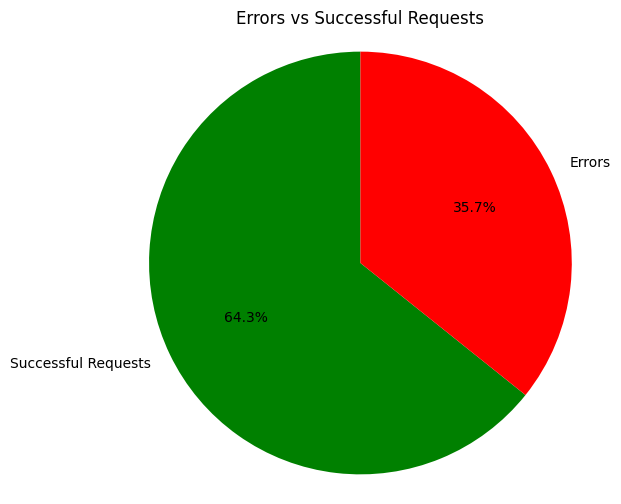

In [ ]:
import matplotlib.pyplot as plt
# Convert the PySpark DataFrame to a Pandas DataFrame for easier manipulation
error_rate_pandas = error_rate_df.toPandas()
# Extract data for the pie chart
labels = ['Successful Requests', 'Errors']
sizes = [
    error_rate_pandas[error_rate_pandas['is_error'] == 0]['error_rate'].values[0],
    error_rate_pandas[error_rate_pandas['is_error'] == 1]['error_rate'].values[0]
]
# Generate the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
plt.title('Errors vs Successful Requests')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.show()


this query further drills down on the error analysis to find the distribution of the type of error generated whether they are server side errors(500 status code) or user generated errors(400 staus code)

In [ ]:
client_error_count = web_logs.filter((web_logs.HttpStatusCode >= 400) & (web_logs.HttpStatusCode < 500)).count()
print(f"Number of client side errors : {client_error_count}")
server_error_count = web_logs.filter((web_logs.HttpStatusCode >= 500) & (web_logs.HttpStatusCode < 600)).count()
print(f"Number of serverside errors: {server_error_count}")

Number of client side errors : 857598
Number of serverside errors: 214527


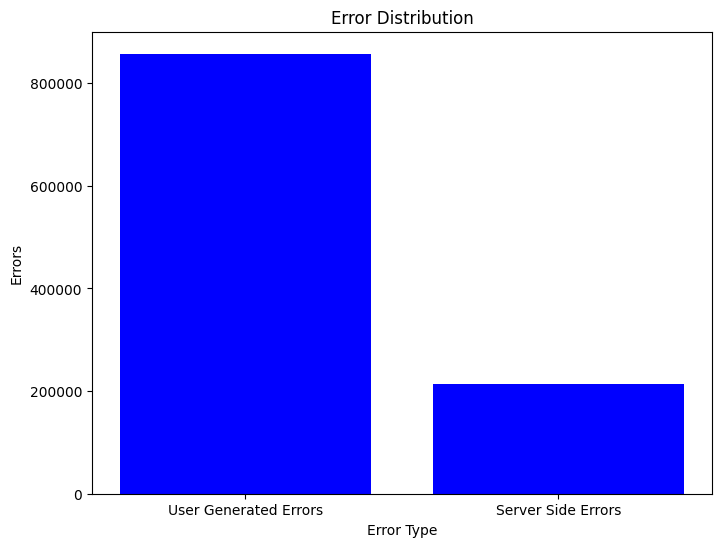

In [ ]:
# Bar graph to visualize the distribution of errors between user generated errors & server side errors
error_counts = {
    "User Generated Errors": client_error_count,
    "Server Side Errors": server_error_count,
}
# Extract labels and values for the bar chart
labels = list(error_counts.keys())
values = list(error_counts.values())
# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['blue', 'blue'])
plt.xlabel("Error Type")
plt.ylabel("Errors")
plt.title("Error Distribution")

plt.show()

Second Query
This query ranks url based on the average traffic they get per month. This can give valuable insights into which urls are the most popular and frequented by users

In [ ]:
#Sql query that calculates the avrage monthly users per domain and gives the top15 most poular
query = """
SELECT Url, AVG(monthly_traffic) AS avg_monthly_traffic
FROM (
    SELECT Url, DATE_FORMAT(TimeStamp, 'yyyy-MM') AS month, COUNT(*) AS monthly_traffic
    FROM web_logs
    GROUP BY Url, month
) AS monthly_url_traffic
GROUP BY Url
ORDER BY avg_monthly_traffic DESC
LIMIT 15;
"""
result_df = spark.sql(query)
result_df.show()


+--------------------+-------------------+
|                 Url|avg_monthly_traffic|
+--------------------+-------------------+
|/data-analysis/ap...| 1106.0869565217392|
|     /software/data/| 1103.5652173913043|
|/web-development/...| 1101.8695652173913|
| /history/countdown/| 1101.6521739130435|
|/software/technol...| 1101.1739130434783|
|/security/technol...|  1100.304347826087|
|/networking/deep-...|             1100.0|
|/networking/firew...| 1097.7826086956522|
|/security/countdown/| 1097.3478260869565|
|    /history/apollo/|  1097.304347826087|
|/history/deep-lea...| 1096.6521739130435|
|/data-analysis/co...| 1096.1739130434783|
|  /images/apollo-11/| 1096.1304347826087|
|/machine-learning...| 1095.1304347826087|
|      /history/data/| 1095.0434782608695|
+--------------------+-------------------+



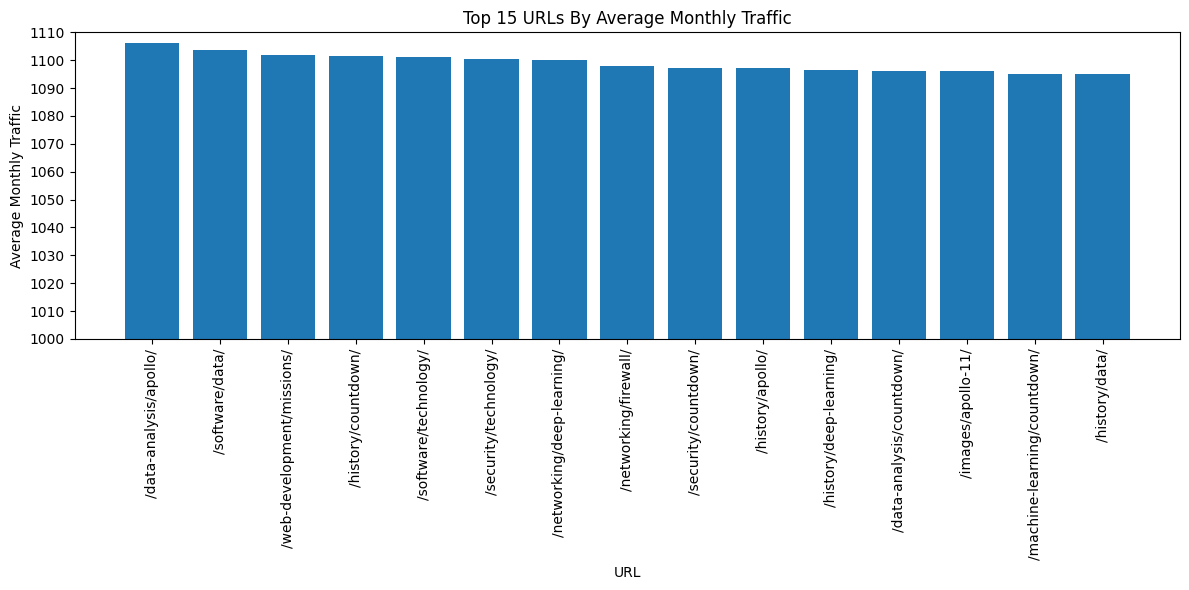

In [ ]:
pdf_result = result_df.toPandas()

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(pdf_result["Url"], pdf_result["avg_monthly_traffic"])
plt.xlabel("URL")
plt.ylabel("Average Monthly Traffic")
plt.title("Top 15 URLs By Average Monthly Traffic")
plt.ylim(1000, 1110)  # Set the limits for the y-axis
plt.yticks(range(1000, 1111, 10))
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


# **Task 2 - Data Processing using PySpark RDD [40 marks]**

---


In [ ]:
import re

# Custom parser function
def parse_log_entry(entry):
    log_pattern = r'^(\S+) - - \[(.*?)\] "(.*?) (.*?) (.*?)" (\d+) (\d+) (.*)$'
    match = re.match(log_pattern, entry)
    if match:
        return {
            "IP": match.group(1),
            "Timestamp": match.group(2),
            "HttpMethod": match.group(3),
            "URL": match.group(4),
            "HttpVersion": match.group(5),
            "StatusCode": int(match.group(6)),
            "ResponseSize": int(match.group(7)),
            "Message": match.group(8),
        }
    else:
        return None  # Handle malformed entries


In [ ]:
log_file_path = "/content/drive/MyDrive/Files/web.log"
logs_rdd = spark.sparkContext.textFile(log_file_path)

# Parse the log entries
parsed_rdd = logs_rdd.map(parse_log_entry).filter(lambda x: x is not None)

# Extract specific fields for basic processing
processed_rdd = parsed_rdd.map(lambda entry: (entry["IP"], entry["Timestamp"], entry["HttpMethod"], entry["URL"], entry["StatusCode"], entry["ResponseSize"], entry["Message"]))

In [ ]:
processed_rdd.take(5)

[('88.211.105.115',
  '04/Mar/2022:14:17:48',
  'POST',
  '/history/missions/',
  414,
  12456,
  'Caution: System may require attention. Check logs for details.'),
 ('144.6.49.142',
  '02/Sep/2022:15:16:00',
  'POST',
  '/security/firewall/',
  203,
  97126,
  'Warning: Unusual behavior detected. Investigate further.'),
 ('231.70.64.145',
  '19/Jul/2022:01:31:31',
  'PUT',
  '/web-development/countdown/',
  201,
  33093,
  'Informational message. No action required.'),
 ('219.42.234.172',
  '08/Feb/2022:11:34:57',
  'POST',
  '/networking/technology/',
  415,
  68827,
  'Debug: Detailed system state information.'),
 ('183.173.185.94',
  '29/Aug/2023:03:07:11',
  'GET',
  '/security/firewall/',
  205,
  30374,
  'Warning: Unusual behavior detected. Investigate further.')]

# **One Basic RDD Analysis**

A log level or log severity is a piece of information telling how important a given log message is. It is a simple, yet very powerful way of distinguishing log events from each other. This query checks the requests that return a warning as part of their message. A warningt log level indicates that something unexpected happened in the application, a problem, or a situation that might disturb one of the processes. But that doesn’t mean that the application failed.

In [ ]:
# Filter the RDD for rows with the log level warning in the message
warning_messages = parsed_rdd.filter(lambda x: "Warning" in x['Message'])

# Collect and display the results
for request in warning_messages.take(30):
    print(request)

{'IP': '144.6.49.142', 'Timestamp': '02/Sep/2022:15:16:00', 'HttpMethod': 'POST', 'URL': '/security/firewall/', 'HttpVersion': 'HTTPS/1.0', 'StatusCode': 203, 'ResponseSize': 97126, 'Message': 'Warning: Unusual behavior detected. Investigate further.'}
{'IP': '183.173.185.94', 'Timestamp': '29/Aug/2023:03:07:11', 'HttpMethod': 'GET', 'URL': '/security/firewall/', 'HttpVersion': 'HTTP/2.0', 'StatusCode': 205, 'ResponseSize': 30374, 'Message': 'Warning: Unusual behavior detected. Investigate further.'}
{'IP': '12.33.251.59', 'Timestamp': '15/Aug/2022:15:59:37', 'HttpMethod': 'GET', 'URL': '/web-development/data/', 'HttpVersion': 'HTTP/2.0', 'StatusCode': 203, 'ResponseSize': 37029, 'Message': 'Warning: Unusual behavior detected. Investigate further.'}
{'IP': '103.105.160.60', 'Timestamp': '24/Oct/2023:01:54:56', 'HttpMethod': 'GET', 'URL': '/shuttle/cybersecurity/', 'HttpVersion': 'HTTP/1.0', 'StatusCode': 416, 'ResponseSize': 3924, 'Message': 'Warning: Unusual behavior detected. Investi

#**Two Advanced RDD Analysis**

This query finds the top 20 ip adresses that have made the most requests in the logs. This could be useful to a comapny to gain an insight into their most frequent visitors and allow the business to cater to their needs.

In [ ]:
# Map IP addresses to a tuple (IP, 1) and count occurrences
ip_request_counts = (parsed_rdd
                     .map(lambda x: (x['IP'], 1))
                     .reduceByKey(lambda a, b: a + b)  # Aggregate counts by IP
                     .sortBy(lambda x: x[1], ascending=False))  # Sort by count in descending order

# Collect and display the top 20 IPs with the most requests
top_ips = ip_request_counts.take(20)
for ip, count in top_ips:
    print(f"IP: {ip}, Requests: {count}")

IP: 61.203.220.155, Requests: 2
IP: 225.2.68.42, Requests: 2
IP: 189.15.120.110, Requests: 2
IP: 190.63.218.54, Requests: 2
IP: 18.133.225.189, Requests: 2
IP: 94.197.23.111, Requests: 2
IP: 221.28.12.178, Requests: 2
IP: 11.161.68.4, Requests: 2
IP: 146.73.243.9, Requests: 2
IP: 240.63.45.243, Requests: 2
IP: 147.243.61.67, Requests: 2
IP: 198.103.243.30, Requests: 2
IP: 199.11.17.127, Requests: 2
IP: 2.235.47.16, Requests: 2
IP: 223.78.179.107, Requests: 2
IP: 101.41.70.77, Requests: 2
IP: 137.230.40.139, Requests: 2
IP: 180.206.85.128, Requests: 2
IP: 114.237.203.188, Requests: 2
IP: 200.113.99.229, Requests: 2


The query has a look at the requests that weren't completed and gropups them by url to give a picture of which urls had the most failed requests

In [ ]:
# Filter failed requests and group by URL
failed_requests = parsed_rdd.filter(lambda x: x['StatusCode'] != 200).map(lambda x: (x['URL'], 1)).groupByKey()

# Count failed requests for each URL
failed_request_counts = failed_requests.mapValues(lambda failures: sum(failures))

# Collect and display the results
for url, count in failed_request_counts.collect():
    print(f"URL: {url}, Failed Requests: {count}")

URL: /security/firewall/, Failed Requests: 23120
URL: /history/apollo-11/, Failed Requests: 22881
URL: /shuttle/data/, Failed Requests: 23164
URL: /web-development/firewall/, Failed Requests: 23022
URL: /machine-learning/apollo-11/, Failed Requests: 23020
URL: /machine-learning/technology/, Failed Requests: 22910
URL: /web-development/deep-learning/, Failed Requests: 23285
URL: /images/firewall/, Failed Requests: 22959
URL: /software/data/, Failed Requests: 23552
URL: /images/apollo-11/, Failed Requests: 23477
URL: /security/launch/, Failed Requests: 23048
URL: /shuttle/cybersecurity/, Failed Requests: 23297
URL: /software/apollo-11/, Failed Requests: 23271
URL: /security/missions/, Failed Requests: 23052
URL: /data-analysis/cybersecurity/, Failed Requests: 23365
URL: /machine-learning/cybersecurity/, Failed Requests: 23186
URL: /networking/aws-certification/, Failed Requests: 23048
URL: /shuttle/apollo-11/, Failed Requests: 23231
URL: /software/firewall/, Failed Requests: 23239
URL: /

The insights gained by this query are basically finding the urls with the most errors since we'd previously established most failed requests to the system are due to user generated errors, we can gain an insight on which url users tend to have trouble accesing. This allows the business to optimize their url to try and minimize the errors

#Caching vs No Caching
Examining the impact of caching on the query times. The caching method chosen was caching on memory and disk to see the results. The impact of caching was that he query ran faster going from 9.81 seconds total time when not cached to 1.17 seconds when cached

In [ ]:

%%time
from pyspark.sql.functions import col, when, count
# Grouping requests by month to observe traffic trends through the year
from pyspark.sql.functions import month
# Extract the month from the timestamp
monthly_trends = web_logs.withColumn("Month", month("TimeStamp")) \
                            .groupBy("Month") \
                            .agg(count("*").alias("RequestCount")) \
                            .orderBy("Month")
monthly_trends.show()

+-----+------------+
|Month|RequestCount|
+-----+------------+
|    1|      272705|
|    2|      246195|
|    3|      271725|
|    4|      264551|
|    5|      273201|
|    6|      263867|
|    7|      273207|
|    8|      272551|
|    9|      264382|
|   10|      272960|
|   11|      188249|
|   12|      136407|
+-----+------------+

CPU times: user 92.6 ms, sys: 7.71 ms, total: 100 ms
Wall time: 12.7 s


In [ ]:
%%time
#cached
from pyspark import StorageLevel
web_logs.persist(StorageLevel.MEMORY_AND_DISK)
# Grouping requests by month to observe traffic trends through the year
from pyspark.sql.functions import month
# Extract the month from the timestamp
monthly_trends = web_logs.withColumn("Month", month("TimeStamp")) \
                            .groupBy("Month") \
                            .agg(count("*").alias("RequestCount")) \
                            .orderBy("Month")
monthly_trends.show()


+-----+------------+
|Month|RequestCount|
+-----+------------+
|    1|      272705|
|    2|      246195|
|    3|      271725|
|    4|      264551|
|    5|      273201|
|    6|      263867|
|    7|      273207|
|    8|      272551|
|    9|      264382|
|   10|      272960|
|   11|      188249|
|   12|      136407|
+-----+------------+

CPU times: user 458 ms, sys: 48.6 ms, total: 506 ms
Wall time: 1min 20s


In [ ]:
%%time
# Extract the month from the timestamp
monthly_trends = web_logs.withColumn("Month", month("TimeStamp")) \
                            .groupBy("Month") \
                            .agg(count("*").alias("RequestCount")) \
                            .orderBy("Month")
monthly_trends.show()

+-----+------------+
|Month|RequestCount|
+-----+------------+
|    1|      272705|
|    2|      246195|
|    3|      271725|
|    4|      264551|
|    5|      273201|
|    6|      263867|
|    7|      273207|
|    8|      272551|
|    9|      264382|
|   10|      272960|
|   11|      188249|
|   12|      136407|
+-----+------------+

CPU times: user 21.3 ms, sys: 2.23 ms, total: 23.6 ms
Wall time: 1.72 s


#Partitioning
Examining different repartitoning techniques and their imapct. We look into two techniques a repartitioning operation and a coalacing operation. Repartioning fully shuffles the data and redistributes it equally in the partitions while coalacing doesn't perform a full shuffling operation thus the data isn't well balanced in the partitons. The repartitoning was done to have an even number of partitions(8) to maximize parallel proccessing. The impact in time was significant with the repartiontioned data which had 128 mb per partition performing the query in 15.6 seconds compared to 40.7 seconds for the default data without repartioning and 44.5 seconds for the coalaced data

In [ ]:
#check the number of default partitions
print(parsed_rdd.getNumPartitions())

13


In [ ]:
# check the number of records in each partition
partition_data = parsed_rdd.glom().collect()
for i, partition in enumerate(partition_data):
    print(f"Partition {i} has {len(partition)} records")


Partition 0 has 233183 records
Partition 1 has 233160 records
Partition 2 has 233177 records
Partition 3 has 233219 records
Partition 4 has 233140 records
Partition 5 has 233188 records
Partition 6 has 233200 records
Partition 7 has 233173 records
Partition 8 has 233156 records
Partition 9 has 233191 records
Partition 10 has 233186 records
Partition 11 has 233197 records
Partition 12 has 201830 records


In [ ]:
# check the size in memory of each partiton
import sys

def get_partition_sizes(rdd):
    partition_sizes = (
        rdd.mapPartitions(lambda partition: [sum(sys.getsizeof(record) for record in partition)])
        .collect()
    )
    return partition_sizes
partition_sizes = get_partition_sizes(parsed_rdd)
for i, size in enumerate(partition_sizes):
    print(f"Partition {i}: {size} bytes")
def format_size(size_in_bytes):
    for unit in ['B', 'KB', 'MB', 'GB']:
        if size_in_bytes < 1024:
            return f"{size_in_bytes:.2f} {unit}"
        size_in_bytes /= 1024
    return f"{size_in_bytes:.2f} TB"

for i, size in enumerate(partition_sizes):
    print(f"Partition {i}: {format_size(size)}")

Partition 0: 83945880 bytes
Partition 1: 83937600 bytes
Partition 2: 83943720 bytes
Partition 3: 83958840 bytes
Partition 4: 83930400 bytes
Partition 5: 83947680 bytes
Partition 6: 83952000 bytes
Partition 7: 83942280 bytes
Partition 8: 83936160 bytes
Partition 9: 83948760 bytes
Partition 10: 83946960 bytes
Partition 11: 83950920 bytes
Partition 12: 72658800 bytes
Partition 0: 80.06 MB
Partition 1: 80.05 MB
Partition 2: 80.05 MB
Partition 3: 80.07 MB
Partition 4: 80.04 MB
Partition 5: 80.06 MB
Partition 6: 80.06 MB
Partition 7: 80.05 MB
Partition 8: 80.05 MB
Partition 9: 80.06 MB
Partition 10: 80.06 MB
Partition 11: 80.06 MB
Partition 12: 69.29 MB


In [ ]:
coalaced_rdd = parsed_rdd.coalesce(8)  #  Coalesce
print(f"Number of partitions after coalacing: {coalaced_rdd.getNumPartitions()}")

Number of partitions after coalacing: 8


In [ ]:
partition_data = coalaced_rdd.glom().collect()
for i, partition in enumerate(partition_data):
    print(f"Partition {i} has {len(partition)} records")

Partition 0 has 233183 records
Partition 1 has 466337 records
Partition 2 has 233219 records
Partition 3 has 466328 records
Partition 4 has 466373 records
Partition 5 has 233156 records
Partition 6 has 466377 records
Partition 7 has 435027 records


In [ ]:
import sys

def get_partition_sizes(rdd):
    partition_sizes = (
        rdd.mapPartitions(lambda partition: [sum(sys.getsizeof(record) for record in partition)])
        .collect()
    )
    return partition_sizes
partition_sizes = get_partition_sizes(coalaced_rdd)
for i, size in enumerate(partition_sizes):
    print(f"Partition {i}: {size} bytes")
def format_size(size_in_bytes):
    for unit in ['B', 'KB', 'MB', 'GB']:
        if size_in_bytes < 1024:
            return f"{size_in_bytes:.2f} {unit}"
        size_in_bytes /= 1024
    return f"{size_in_bytes:.2f} TB"

for i, size in enumerate(partition_sizes):
    print(f"Partition {i}: {format_size(size)}")

Partition 0: 83945880 bytes
Partition 1: 167881320 bytes
Partition 2: 83958840 bytes
Partition 3: 167878080 bytes
Partition 4: 167894280 bytes
Partition 5: 83936160 bytes
Partition 6: 167895720 bytes
Partition 7: 156609720 bytes
Partition 0: 80.06 MB
Partition 1: 160.10 MB
Partition 2: 80.07 MB
Partition 3: 160.10 MB
Partition 4: 160.12 MB
Partition 5: 80.05 MB
Partition 6: 160.12 MB
Partition 7: 149.35 MB


In [ ]:
repartitioned_rdd = parsed_rdd.repartition(8)
print(f"Number of partitions after repartitioning: {repartitioned_rdd.getNumPartitions()}")


Number of partitions after repartitioning: 8


In [ ]:
new_partition_data = repartitioned_rdd.glom().collect()
for i, partition in enumerate(new_partition_data):
    print(f"Partition {i} has {len(partition)} records")

Partition 0 has 374995 records
Partition 1 has 374973 records
Partition 2 has 375000 records
Partition 3 has 375000 records
Partition 4 has 375000 records
Partition 5 has 375015 records
Partition 6 has 375018 records
Partition 7 has 374999 records


In [ ]:
import sys

def get_partition_sizes(rdd):
    partition_sizes = (
        rdd.mapPartitions(lambda partition: [sum(sys.getsizeof(record) for record in partition)])
        .collect()
    )
    return partition_sizes
partition_sizes = get_partition_sizes(repartitioned_rdd)
for i, size in enumerate(partition_sizes):
    print(f"Partition {i}: {size} bytes")
def format_size(size_in_bytes):
    for unit in ['B', 'KB', 'MB', 'GB']:
        if size_in_bytes < 1024:
            return f"{size_in_bytes:.2f} {unit}"
        size_in_bytes /= 1024
    return f"{size_in_bytes:.2f} TB"

for i, size in enumerate(partition_sizes):
    print(f"Partition {i}: {format_size(size)}")

Partition 0: 134998200 bytes
Partition 1: 134990280 bytes
Partition 2: 135000000 bytes
Partition 3: 135000000 bytes
Partition 4: 135000000 bytes
Partition 5: 135005400 bytes
Partition 6: 135006480 bytes
Partition 7: 134999640 bytes
Partition 0: 128.74 MB
Partition 1: 128.74 MB
Partition 2: 128.75 MB
Partition 3: 128.75 MB
Partition 4: 128.75 MB
Partition 5: 128.75 MB
Partition 6: 128.75 MB
Partition 7: 128.75 MB


In [ ]:
%%time
# Extract hour from the Timestamp field
hourly_requests = (parsed_rdd
                   .map(lambda x: (int(x['Timestamp'].split(":")[1]), 1))  # Extract hour and map to (hour, 1) using the 'Timestamp' key
                   .reduceByKey(lambda a, b: a + b)             # Aggregate counts by hour
                   .sortByKey())                                # Sort by hour

# Collect and display results
for hour, count in hourly_requests.collect():
    print(f"Hour: {hour}, Requests: {count}")

Hour: 0, Requests: 125373
Hour: 1, Requests: 124866
Hour: 2, Requests: 125019
Hour: 3, Requests: 124947
Hour: 4, Requests: 125239
Hour: 5, Requests: 125049
Hour: 6, Requests: 125200
Hour: 7, Requests: 124930
Hour: 8, Requests: 124976
Hour: 9, Requests: 125056
Hour: 10, Requests: 124963
Hour: 11, Requests: 124603
Hour: 12, Requests: 124817
Hour: 13, Requests: 124634
Hour: 14, Requests: 125461
Hour: 15, Requests: 125812
Hour: 16, Requests: 125191
Hour: 17, Requests: 124644
Hour: 18, Requests: 124872
Hour: 19, Requests: 124683
Hour: 20, Requests: 125038
Hour: 21, Requests: 124833
Hour: 22, Requests: 125051
Hour: 23, Requests: 124743
CPU times: user 227 ms, sys: 31.4 ms, total: 258 ms
Wall time: 40.7 s


In [ ]:
%%time
# Extract hour from the Timestamp field
hourly_requests = (coalaced_rdd
                   .map(lambda x: (int(x['Timestamp'].split(":")[1]), 1))  # Extract hour and map to (hour, 1) using the 'Timestamp' key
                   .reduceByKey(lambda a, b: a + b)             # Aggregate counts by hour
                   .sortByKey())                                # Sort by hour

# Collect and display results
for hour, count in hourly_requests.collect():
    print(f"Hour: {hour}, Requests: {count}")

Hour: 0, Requests: 125373
Hour: 1, Requests: 124866
Hour: 2, Requests: 125019
Hour: 3, Requests: 124947
Hour: 4, Requests: 125239
Hour: 5, Requests: 125049
Hour: 6, Requests: 125200
Hour: 7, Requests: 124930
Hour: 8, Requests: 124976
Hour: 9, Requests: 125056
Hour: 10, Requests: 124963
Hour: 11, Requests: 124603
Hour: 12, Requests: 124817
Hour: 13, Requests: 124634
Hour: 14, Requests: 125461
Hour: 15, Requests: 125812
Hour: 16, Requests: 125191
Hour: 17, Requests: 124644
Hour: 18, Requests: 124872
Hour: 19, Requests: 124683
Hour: 20, Requests: 125038
Hour: 21, Requests: 124833
Hour: 22, Requests: 125051
Hour: 23, Requests: 124743
CPU times: user 238 ms, sys: 34 ms, total: 272 ms
Wall time: 44.5 s


In [ ]:
%%time
# Extract hour from the Timestamp field
hourly_requests = (repartitioned_rdd
                   .map(lambda x: (int(x['Timestamp'].split(":")[1]), 1))  # Extract hour and map to (hour, 1) using the 'Timestamp' key
                   .reduceByKey(lambda a, b: a + b)             # Aggregate counts by hour
                   .sortByKey())                                # Sort by hour

# Collect and display results
for hour, count in hourly_requests.collect():
    print(f"Hour: {hour}, Requests: {count}")

Hour: 0, Requests: 125373
Hour: 1, Requests: 124866
Hour: 2, Requests: 125019
Hour: 3, Requests: 124947
Hour: 4, Requests: 125239
Hour: 5, Requests: 125049
Hour: 6, Requests: 125200
Hour: 7, Requests: 124930
Hour: 8, Requests: 124976
Hour: 9, Requests: 125056
Hour: 10, Requests: 124963
Hour: 11, Requests: 124603
Hour: 12, Requests: 124817
Hour: 13, Requests: 124634
Hour: 14, Requests: 125461
Hour: 15, Requests: 125812
Hour: 16, Requests: 125191
Hour: 17, Requests: 124644
Hour: 18, Requests: 124872
Hour: 19, Requests: 124683
Hour: 20, Requests: 125038
Hour: 21, Requests: 124833
Hour: 22, Requests: 125051
Hour: 23, Requests: 124743
CPU times: user 107 ms, sys: 15 ms, total: 122 ms
Wall time: 15.6 s
